# Uncertainty Evaluation, Ensembles, Dropout and SWAG

Source: https://github.com/wjmaddox/swa_gaussian

## Some set up

In [1]:
!git clone https://github.com/wjmaddox/swa_gaussian.git

fatal: destination path 'swa_gaussian' already exists and is not an empty directory.


⚡️ Tip	Connect GitHub to Studios: https://lightning.ai/dm5182/home?settings=integrations



In [2]:
cd swa_gaussian/

/teamspace/studios/this_studio/DS-GA-1003-Machine-Learning-2025/lab10/swa_gaussian


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
ls

LICENSE*     experiments/             short_slides.pdf*  swag_ckpts.zip*
README.md*   neurips2019_poster.pdf*  slides.pdf*        tests/
README.rst*  plots/                   swa_gaussian/
ckpts/       requirements.txt*        swag/
datasets/    setup.py*                swag.egg-info/


In [4]:
pip install -e .

Obtaining file:///teamspace/studios/this_studio/DS-GA-1003-Machine-Learning-2025/lab10/swa_gaussian
  Preparing metadata (setup.py) ... done
  Attempting uninstall: swag
    Found existing installation: swag 0.0
    Uninstalling swag-0.0:
      Successfully uninstalled swag-0.0
  DEPRECATION: Legacy editable install of swag==0.0 from file:///teamspace/studios/this_studio/DS-GA-1003-Machine-Learning-2025/lab10/swa_gaussian (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for swag

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Not

In [5]:
!pip install gpytorch==1.12.0


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
import argparse
import os, sys
import time
import tabulate
import tqdm

import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from matplotlib import pyplot as plt

from swag import data, models, utils, losses
from swag.posteriors import SWAG

%matplotlib inline

## Loading the Model and Data

In [7]:
model_cfg = models.PreResNet56
loaders, num_classes = data.loaders(
    "CIFAR100",
    "./datasets/",
    128,
    4,
    model_cfg.transform_train,
    model_cfg.transform_test,
    use_validation=False,
    split_classes=None,
)

model = model_cfg.base(*model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
model.cuda()

criterion = losses.cross_entropy

Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


### Let's load a pre-trained checkpoint for a model trained with SGD and compute predictions

In [8]:
!wget https://nyu.box.com/shared/static/04puv1xfl146j6ic2qdkpqoc74t5ul6v.zip; mv 04puv1xfl146j6ic2qdkpqoc74t5ul6v.zip swag_ckpts.zip

--2025-04-09 20:50:02--  https://nyu.box.com/shared/static/04puv1xfl146j6ic2qdkpqoc74t5ul6v.zip
Resolving nyu.box.com (nyu.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to nyu.box.com (nyu.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/04puv1xfl146j6ic2qdkpqoc74t5ul6v.zip [following]
--2025-04-09 20:50:02--  https://nyu.box.com/public/static/04puv1xfl146j6ic2qdkpqoc74t5ul6v.zip
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/04puv1xfl146j6ic2qdkpqoc74t5ul6v.zip [following]
--2025-04-09 20:50:03--  https://nyu.app.box.com/public/static/04puv1xfl146j6ic2qdkpqoc74t5ul6v.zip
Resolving nyu.app.box.com (nyu.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to nyu.app.box.com (nyu.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 302 Found
L

In [9]:
ls

LICENSE*     datasets/                requirements.txt*  swa_gaussian/   tests/
README.md*   experiments/             setup.py*          swag/
README.rst*  neurips2019_poster.pdf*  short_slides.pdf*  swag.egg-info/
ckpts/       plots/                   slides.pdf*        swag_ckpts.zip


In [10]:
!unzip -qn swag_ckpts.zip


In [11]:
ls ckpts/c100/preresnet56/

dropout1/  sgd1/  sgd2/  sgd3/  sgd4/  swag1/


In [12]:
checkpoint = torch.load("ckpts/c100/preresnet56/sgd1/checkpoint-300.pt")
model.load_state_dict(checkpoint["state_dict"])
model.eval()
probs, targets = utils.predictions(loaders["test"], model)
preds = np.argmax(probs, axis=-1)

## Uncertainty evaluation:

* Accuracy
* NLL
* Calibration

In [13]:
acc = (preds == targets).mean()
print(acc)

0.7379


### NLL

Negative log likelihood:
$$-\log p(y) = -\sum_{i=1}^N \log p(y_i), $$
where $p(y_i) = p(y_i \vert x_i, w)$ is the predicted probability corresponding to the correct class $y_i$. The lower NLL, the better. NLL depends on both accuracy and uncertainty calibration.

In [14]:
def get_nll(probs, targets):
    labels = targets.astype(int)
    idx = (np.arange(targets.size), targets)
    ps = probs[idx]
    nll = -np.sum(np.log(ps))
    return nll

In [15]:
get_nll(probs, targets)

11208.036

### Calibration

We want $$\text{model confidence} \approx \text{probability of accurate prediction}.$$

We can measure calibration as follows.
- Bin all datapoints into $n$ bins according to model confidence (largest softmax output)
- Compute the accuracy within each bin
- Plot confidence vs accuracy to get calibration curve
- Average the $|\text{confidence} - \text{accuracy}|$ over bins to get Expected Calibration Error

Paper on calibration of DNNs: https://arxiv.org/abs/1706.04599

In [16]:
def calibration_curve(outputs, labels, num_bins=20):
    """Compute calibration curve and ECE."""
    confidences = np.max(outputs, 1)
    num_inputs = confidences.shape[0]
    step = (num_inputs + num_bins - 1) // num_bins
    bins = np.sort(confidences)[::step]
    if num_inputs % step != 1:
        bins = np.concatenate((bins, [np.max(confidences)]))
    predictions = np.argmax(outputs, 1)
    bin_lowers = bins[:-1]
    bin_uppers = bins[1:]

    accuracies = (predictions == labels)

    bin_confidences = []
    bin_accuracies = []
    bin_proportions = []

    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) * (confidences < bin_upper)
        prop_in_bin = in_bin.mean()
        if prop_in_bin > 0:
            accuracy_in_bin = accuracies[in_bin].mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            bin_confidences.append(avg_confidence_in_bin)
            bin_accuracies.append(accuracy_in_bin)
            bin_proportions.append(prop_in_bin)

    bin_confidences, bin_accuracies, bin_proportions = map(
          lambda lst: np.array(lst),
          (bin_confidences, bin_accuracies, bin_proportions))

    return {
      "confidence": bin_confidences,
      "accuracy": bin_accuracies,
      "proportions": bin_proportions,
      "ece": ece}

In [17]:
calibration_dict = calibration_curve(probs, targets)
print(calibration_dict["ece"])

0.12393936201930046


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

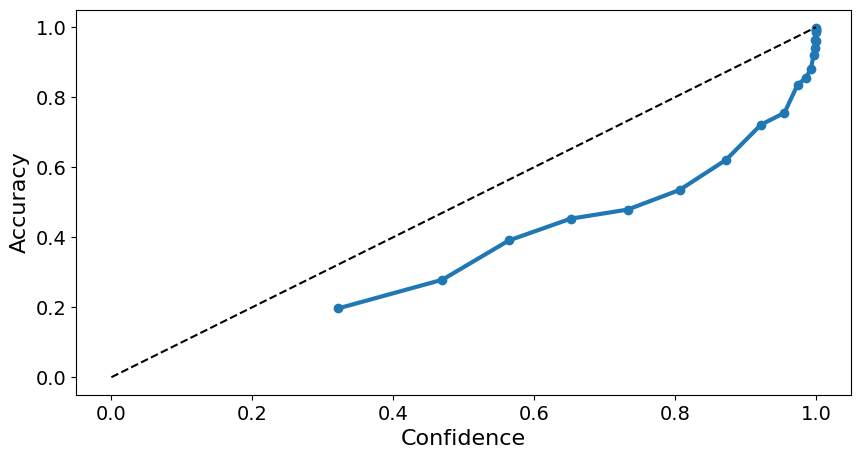

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(calibration_dict["confidence"], calibration_dict["accuracy"], "-o", lw=3)
plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Confidence", fontsize=16)
plt.plot([0, 1], [0, 1], "--k")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Ensembling

Paper: https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf

In [19]:
all_probs = []
all_logits = []
for run in range(1, 5):
    checkpoint = torch.load("ckpts/c100/preresnet56/sgd{}/checkpoint-300.pt".format(run))
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    probs, targets = utils.predictions(loaders["test"], model)
    logits, _ = utils.predictions(loaders["test"], model, regression=True)

    all_probs.append(probs)
    all_logits.append(logits)

all_probs = np.array(all_probs)
all_logits = np.array(all_logits)

# Probabilities: expect (0, 1)
# Logits: can be any real number


First, let's look at individual models

(4, 10000, 100)
Accuracy: 0.7379	 NLL: 11208.0361328125	 ECE: 0.12393936201930046
Accuracy: 0.7442	 NLL: 11180.4765625	 ECE: 0.11498496731817724
Accuracy: 0.7517	 NLL: 10659.64453125	 ECE: 0.10826653873920439
Accuracy: 0.7425	 NLL: 11030.255859375	 ECE: 0.11501604153215886


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

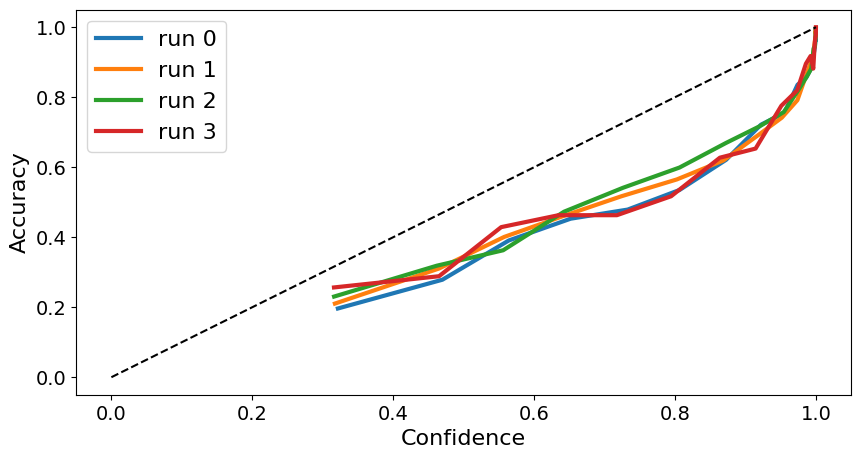

In [20]:
plt.figure(figsize=(10, 5))
print(all_probs.shape)
for run, probs in enumerate(all_probs):
    preds = np.argmax(probs, axis=-1)
    acc = (preds == targets).mean()
    nll = get_nll(probs, targets)
    calibration_dict = calibration_curve(probs, targets)
    print("Accuracy: {}\t NLL: {}\t ECE: {}".format(acc, nll, calibration_dict["ece"]))
    plt.plot(calibration_dict["confidence"], calibration_dict["accuracy"], lw=3,
             label="run {}".format(run))

plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Confidence", fontsize=16)
plt.legend(fontsize=16)
plt.plot([0, 1], [0, 1], "--k")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Now, let's try to ensemble the models

Mixture Ensemble → Accuracy: 0.7919 | NLL: 7680.9360 | ECE: 0.0211


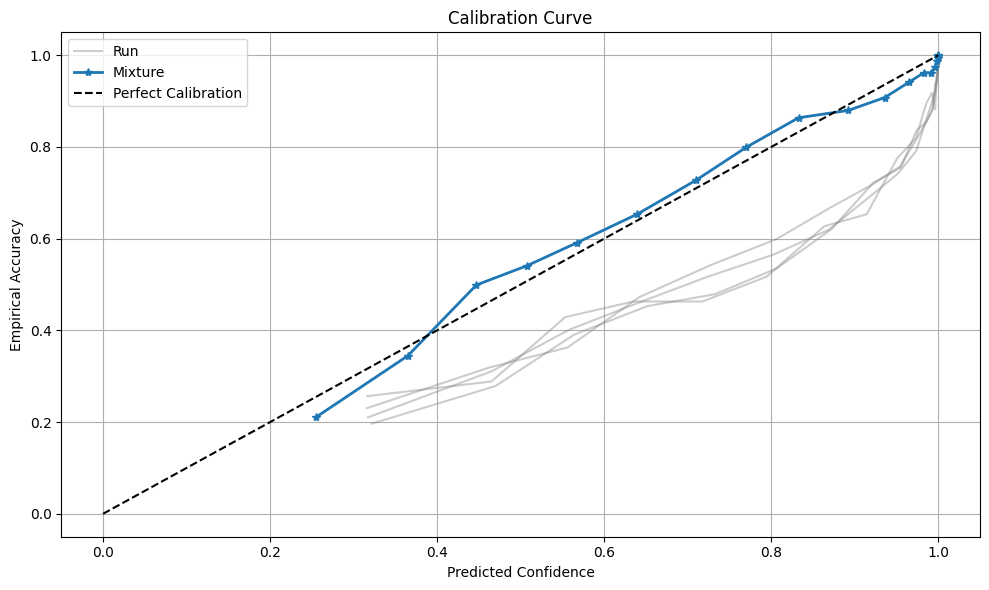

In [21]:
def softmax(x, axis=-1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

def evaluate(probs, label):
    preds = np.argmax(probs, axis=-1)
    acc = (preds == targets).mean()
    nll = get_nll(probs, targets)
    cal = calibration_curve(probs, targets)
    print(f"{label} → Accuracy: {acc:.4f} | NLL: {nll:.4f} | ECE: {cal['ece']:.4f}")
    return cal

mixture_probs = all_probs.mean(axis=0)

plt.figure(figsize=(10, 6))

for i, run_probs in enumerate(all_probs):
    cal = calibration_curve(run_probs, targets)
    plt.plot(cal["confidence"], cal["accuracy"], color="gray", alpha=0.4, label="Run" if i == 0 else None)

cal_mix = evaluate(mixture_probs, "Mixture Ensemble")

plt.plot(cal_mix["confidence"], cal_mix["accuracy"], "-*", label="Mixture", linewidth=2)
plt.plot([0, 1], [0, 1], "--", color="black", label="Perfect Calibration")

plt.title("Calibration Curve")
plt.xlabel("Predicted Confidence")
plt.ylabel("Empirical Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

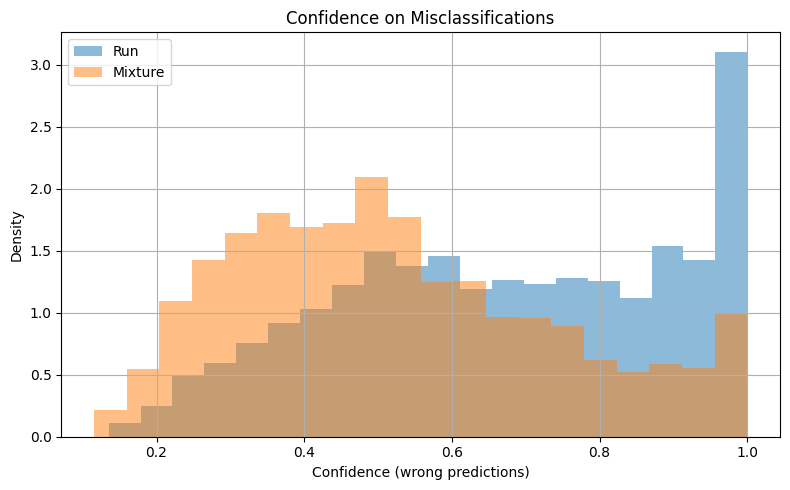

In [24]:
def plot_wrong_confidence(probs, label):
    preds = np.argmax(probs, axis=-1)
    conf = np.max(probs, axis=-1)
    wrong = preds != targets
    plt.hist(conf[wrong], bins=20, alpha=0.5, label=label, density=True)

plt.figure(figsize=(8, 5))
plot_wrong_confidence(probs, "Run")
plot_wrong_confidence(mixture_probs, "Mixture")
plt.title("Confidence on Misclassifications")
plt.xlabel("Confidence (wrong predictions)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Train time compute for one classifier : M, \\
Train time compute for ensemble : ?

Train time compute for one classifier : N, \\
Train time compute for ensemble : ?

Memory requirement for one classifier : L, \\
Memory requirement for ensemble : ?